In [14]:
#imports


from __future__ import print_function

import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

/Users/tyronehou/.virtualenvs/pytorch/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [15]:
# Import the data
# Data shape 5 dim vector []

### Hyperparameters

In [16]:
batch_size = 1000   # num of training examples to train on in a batch
limit_timesteps = 5 # sequence length
num_hidden_layers = 51
state_dim = 3 # dimensions of the state variable passed as input to the LSTM model

future = 2

In [17]:
# Sequence model

class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(state_dim, num_hidden_layers)
        self.lstm2 = nn.LSTMCell(num_hidden_layers, num_hidden_layers)
        self.linear = nn.Linear(num_hidden_layers, state_dim)

    def forward(self, input, future = 0):
        outputs = []
        
        h_t = Variable(torch.zeros(input.size(0), num_hidden_layers).double(), requires_grad=False)
        c_t = Variable(torch.zeros(input.size(0), num_hidden_layers).double(), requires_grad=False)
        h_t2 = Variable(torch.zeros(input.size(0), num_hidden_layers).double(), requires_grad=False)
        c_t2 = Variable(torch.zeros(input.size(0), num_hidden_layers).double(), requires_grad=False)
        
        # run 19 times
        # input_t.size = 5 x 5
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            input_t = input_t.squeeze(1)
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            if (future == 0):
                outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        print(outputs.size())
        return outputs

In [18]:
# # set random seed to 0
# np.random.seed(0)
# torch.manual_seed(0)

# load data and make training set
data = pd.read_csv('cleaned/states_2017-08-28-00.csv')
# print(data['NMAC_id'][5])

# data_nparr = data.as_matrix()
# print(data_nparr[0])


# # drop unneeded columns to form matrix to be trained on
# data_matr = data.drop(['NMAC_id', 'alert_1', 'alert_2', 'onground_1', 'onground_2'], axis=1).as_matrix().astype('float')
# # print(data_m)

# restructure data
all_planes = []

count = 0
unique_icao = data.icao24.unique()
for i, name in enumerate(unique_icao):
    if count % 100 == 0: print(count)
    # only get batch size for now
    if count >= batch_size:
        break
    
    # get rows where icao == name (boolean vector)
    selector = data['icao24'] == name
    one_plane_df = data[selector]
    
#     for index, row in one_plane_df.iterrows():
        
    one_plane_df = one_plane_df.drop(['icao24','time','lat','lon', 'baroaltitude', 'heading'], axis=1)
    one_plane_arr = one_plane_df.as_matrix()
    one_plane_arr = one_plane_arr[0:limit_timesteps]
    
    all_planes.append(one_plane_arr)
    
    count += 1

batch = np.asarray(all_planes) # convert to np matrix

0
100
200
300
400
500
600
700
800
900
1000


In [19]:
# Normalize the velocity

flat_batch = np.reshape(batch, (-1, state_dim))
batch -= np.mean(flat_batch, axis=0)
batch /= np.std(flat_batch, axis=0)

In [20]:
input = Variable(torch.from_numpy(batch[100:,:-1,:]), requires_grad=False)
target = Variable(torch.from_numpy(batch[100:,1:,:]), requires_grad=False)
test_input = Variable(torch.from_numpy(batch[:100,:-future,:]), requires_grad=False)
test_target = Variable(torch.from_numpy(batch[:100,-future:,:]), requires_grad=False)
# data = torch.load('traindata.pt')
# input = Variable(torch.from_numpy(data[3:, :-1]), requires_grad=False)
# target = Variable(torch.from_numpy(data[3:, 1:]), requires_grad=False)
# test_input = Variable(torch.from_numpy(data[:3, :-1]), requires_grad=False)
# test_target = Variable(torch.from_numpy(data[:3, 1:]), requires_grad=False)
print(batch[0])
print(batch.shape)
# print(batch)

[[  0.489005   -28.46016176  23.504859  ]
 [  0.489005   -28.46016176  23.504859  ]
 [  0.489005   -28.46016176  23.504859  ]
 [  0.489005   -28.46016176  23.504859  ]
 [  0.489005   -28.46016176  23.504859  ]]
(1000, 5, 3)


In [21]:


# build the model
seq = Sequence()
seq.double()
criterion = nn.MSELoss()

# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

# begin to train
for i in range(10):
    print('STEP: ', i)
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.data.numpy()[0])
        loss.backward()
        return loss
    optimizer.step(closure)
    
    # begin to predict
    pred = seq(test_input, future = future)
#     pred1 = seq(test_input[:1, :, :])
    loss = criterion(pred, test_target)
    print('test loss:', loss.data.numpy()[0])
    y = pred.data.numpy()
print(pred)

#     # draw the result
#     plt.figure(figsize=(30,10))
#     plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
#     plt.xlabel('x', fontsize=20)
#     plt.ylabel('y', fontsize=20)
#     plt.xticks(fontsize=20)
#     plt.yticks(fontsize=20)
#     def draw(yi, color):
#         plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
#         plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
#     draw(y[0], 'r')
#     draw(y[1], 'g')
#     draw(y[2], 'b')
#     plt.savefig('predict%d.pdf'%i)
#     plt.close()


STEP:  0
torch.Size([900, 4, 3])
loss: 0.542852432424
torch.Size([900, 4, 3])
loss: 0.540674564511
torch.Size([900, 4, 3])
loss: 0.530297689841
torch.Size([900, 4, 3])
loss: 0.519949088347
torch.Size([900, 4, 3])
loss: 0.480372710606
torch.Size([900, 4, 3])
loss: 1.08984119236
torch.Size([900, 4, 3])
loss: 0.392000570867
torch.Size([900, 4, 3])
loss: 0.352544563373
torch.Size([900, 4, 3])
loss: 0.401921207137
torch.Size([900, 4, 3])
loss: 0.228923950233
torch.Size([900, 4, 3])
loss: 0.225587485094
torch.Size([900, 4, 3])
loss: 0.220332274406
torch.Size([900, 4, 3])
loss: 0.209719954625
torch.Size([900, 4, 3])
loss: 0.189881997096
torch.Size([900, 4, 3])
loss: 0.173156374396
torch.Size([900, 4, 3])
loss: 0.153032690901
torch.Size([900, 4, 3])
loss: 0.142945747591
torch.Size([900, 4, 3])
loss: 0.137634640582
torch.Size([900, 4, 3])
loss: 0.130339362084
torch.Size([900, 4, 3])
loss: 0.123842053451
torch.Size([100, 2, 3])
test loss: 4.04639010026
STEP:  1
torch.Size([900, 4, 3])
loss: 0.11

torch.Size([900, 4, 3])
loss: 0.00259368416264
torch.Size([900, 4, 3])
loss: 0.00258425653296
torch.Size([900, 4, 3])
loss: 0.00257242818968
torch.Size([900, 4, 3])
loss: 0.00256266549568
torch.Size([900, 4, 3])
loss: 0.00255367019697
torch.Size([900, 4, 3])
loss: 0.00254591847431
torch.Size([900, 4, 3])
loss: 0.00253963125955
torch.Size([900, 4, 3])
loss: 0.00253417746023
torch.Size([900, 4, 3])
loss: 0.0025288201405
torch.Size([900, 4, 3])
loss: 0.00252482958739
torch.Size([900, 4, 3])
loss: 0.00252039428577
torch.Size([900, 4, 3])
loss: 0.00251529118056
torch.Size([100, 2, 3])
test loss: 2.9829867881
STEP:  9
torch.Size([900, 4, 3])
loss: 0.00250847112788
torch.Size([900, 4, 3])
loss: 0.00249902465425
torch.Size([900, 4, 3])
loss: 0.00248888781094
torch.Size([900, 4, 3])
loss: 0.00248019996853
torch.Size([900, 4, 3])
loss: 0.00247318836622
torch.Size([900, 4, 3])
loss: 0.00246539096721
torch.Size([900, 4, 3])
loss: 0.0024583020079
torch.Size([900, 4, 3])
loss: 0.00245194446028
torch

torch.Size([100, 2, 3])
Variable containing:
  0.4890 -28.4602  23.5049
  0.4890 -28.4602  23.5049
  0.4890 -28.4602  23.5049
[torch.DoubleTensor of size 3x3]

[[ 1.29254989 -3.75969335  3.16570255]
 [ 1.14436909 -2.59276472  1.72705418]]


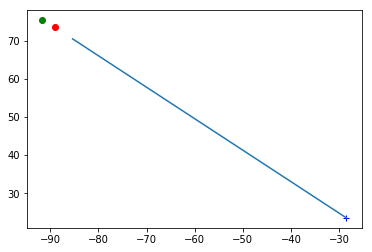

Variable containing:
 1.0325 -0.1552  0.0335
 1.0391 -0.1569  0.0341
 1.0391 -0.1501  0.0312
[torch.DoubleTensor of size 3x3]

[[ 1.03853966 -0.17538695  0.0383992 ]
 [ 1.04440186 -0.17833143  0.0513772 ]]


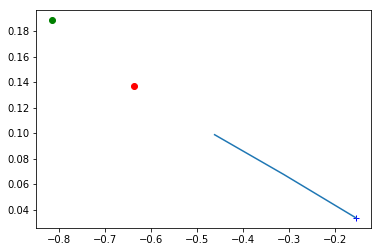

Variable containing:
 1.0164  0.1407 -0.2643
 1.0164  0.1407 -0.2643
 1.0164  0.1407 -0.2643
[torch.DoubleTensor of size 3x3]

[[ 1.01525218  0.1414326  -0.26451007]
 [ 1.02202756  0.15504698 -0.2582746 ]]


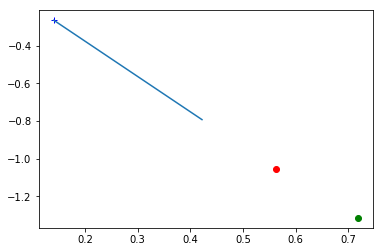

Variable containing:
 0.7768 -0.1390 -0.1745
 0.7809 -0.1403 -0.1756
 0.7823 -0.1381 -0.1734
[torch.DoubleTensor of size 3x3]

[[ 0.78936339 -0.1267314  -0.16522269]
 [ 0.79792217 -0.1085265  -0.15539929]]


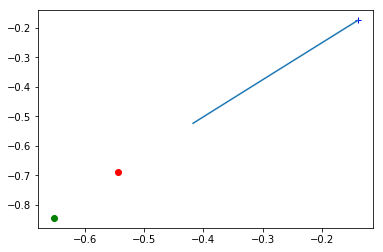

Variable containing:
 0.2566  0.1507  0.0259
 0.2501  0.1734  0.0349
 0.2287  0.1602  0.0295
[torch.DoubleTensor of size 3x3]

[[ 0.22926931  0.13120379  0.03892687]
 [ 0.23230819  0.12697725  0.04172891]]


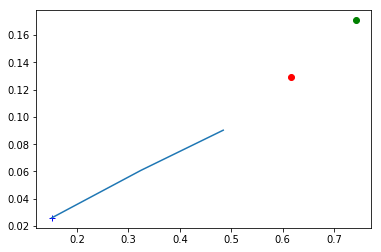

Variable containing:
 0.6630  0.0433 -0.4515
 0.6630  0.0433 -0.4515
 0.6630  0.0433 -0.4515
[torch.DoubleTensor of size 3x3]

[[ 0.67216608  0.03693015 -0.3954783 ]
 [ 0.68100969  0.05005755 -0.3708861 ]]


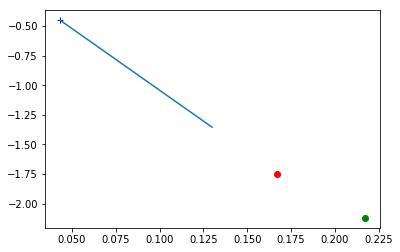

Variable containing:
 0.9527  0.0954 -0.2393
 0.9527  0.1081 -0.2689
 0.9469  0.1000 -0.2524
[torch.DoubleTensor of size 3x3]

[[ 0.9479904   0.10493778 -0.24946201]
 [ 0.95520458  0.11963002 -0.24084443]]


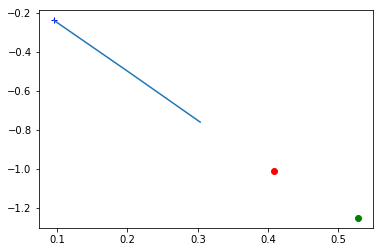

Variable containing:
-1.2025  0.0832 -0.0213
-1.1885  0.0898 -0.0175
-1.1272  0.0821 -0.0193
[torch.DoubleTensor of size 3x3]

[[-1.09071114  0.0907824  -0.01472262]
 [-1.06558892  0.10013687 -0.01057265]]


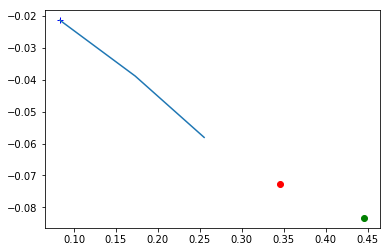

Variable containing:
 0.7469  0.0442 -0.2673
 0.7391  0.0441 -0.2681
 0.7391  0.0432 -0.2647
[torch.DoubleTensor of size 3x3]

[[ 0.74425734  0.04319698 -0.23822227]
 [ 0.75218597  0.05656735 -0.22296148]]


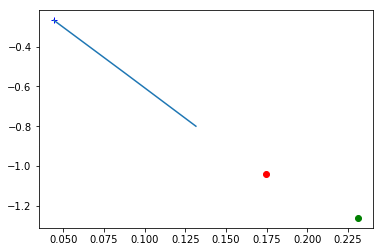

Variable containing:
 0.8324  0.1874 -0.1990
 0.8324  0.1602 -0.1722
 0.8378  0.1712 -0.1829
[torch.DoubleTensor of size 3x3]

[[ 0.83646127  0.15480566 -0.16261777]
 [ 0.84289222  0.16094948 -0.15075532]]


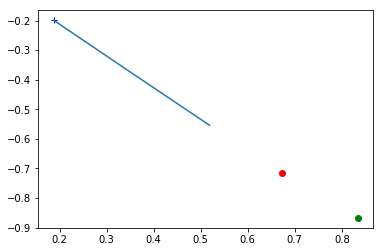

Variable containing:
 0.7930  0.1505 -0.0154
 0.7930  0.1449 -0.0155
 0.7927  0.1653 -0.0144
[torch.DoubleTensor of size 3x3]

[[ 0.78915437  0.15703964 -0.01174362]
 [ 0.79461744  0.16417009 -0.00539013]]


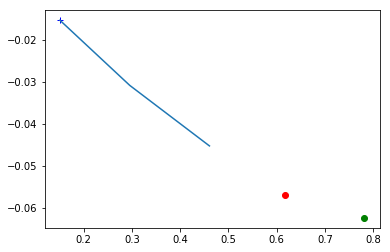

Variable containing:
 0.7035 -0.0671  0.1915
 0.7097 -0.0637  0.1826
 0.7097 -0.0697  0.2005
[torch.DoubleTensor of size 3x3]

[[ 0.71095991 -0.05305861  0.18250478]
 [ 0.71781189 -0.03605578  0.18456259]]


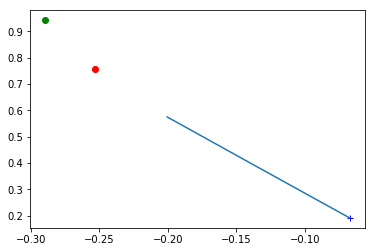

Variable containing:
 0.7457  0.0450 -0.2726
 0.7524  0.0260 -0.1627
 0.7713  0.0422 -0.2804
[torch.DoubleTensor of size 3x3]

[[ 0.77640227  0.03563681 -0.23162875]
 [ 0.78420536  0.04989039 -0.21823362]]


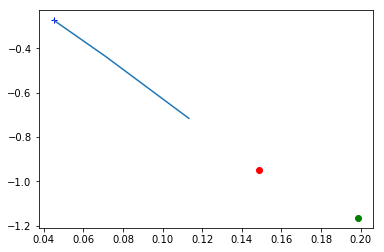

Variable containing:
 0.7065 -0.0266  0.2106
 0.7131 -0.0271  0.2117
 0.7131 -0.0271  0.2089
[torch.DoubleTensor of size 3x3]

[[ 0.71379748 -0.00895717  0.19435619]
 [ 0.72038426  0.00874151  0.19524641]]


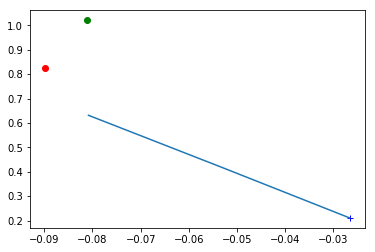

Variable containing:
-0.2074 -0.0768 -0.0174
-0.2551 -0.0943  0.0005
-0.3029 -0.0859 -0.0012
[torch.DoubleTensor of size 3x3]

[[-0.29752248 -0.06802704 -0.01396556]
 [-0.29822625 -0.05463825 -0.01967457]]


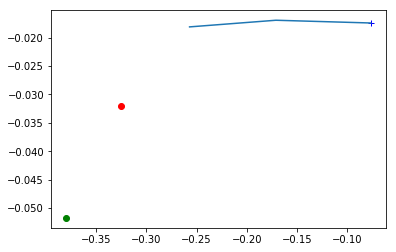

Variable containing:
 1.1126  0.1658  0.0862
 1.1086  0.1569  0.0850
 1.1089  0.1563  0.0839
[torch.DoubleTensor of size 3x3]

[[ 1.10775985  0.16340114  0.074414  ]
 [ 1.11392094  0.17643157  0.07822673]]


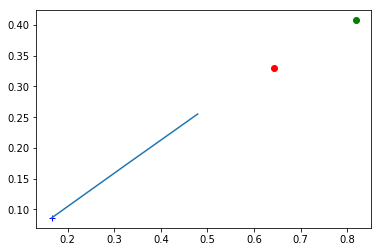

Variable containing:
 0.9229  0.1960  0.1014
 0.9229  0.1960  0.1014
 0.9229  0.1960  0.1014
[torch.DoubleTensor of size 3x3]

[[ 0.92019446  0.20228865  0.08953777]
 [ 0.92580102  0.21361316  0.0916497 ]]


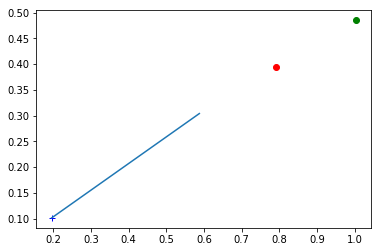

Variable containing:
 1.0774  0.2138 -0.0545
 1.0774  0.2138 -0.0545
 1.0774  0.2138 -0.0545
[torch.DoubleTensor of size 3x3]

[[ 1.0726145   0.21357158 -0.06497393]
 [ 1.07790346  0.22378957 -0.06218726]]


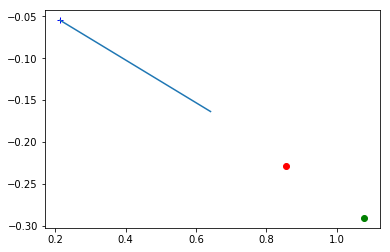

Variable containing:
 0.8616 -3.0160 -2.8690
 0.8616 -0.1293 -0.1593
 0.8582 -0.1528 -0.1809
[torch.DoubleTensor of size 3x3]

[[ 0.88548757 -0.18452637 -0.26649   ]
 [ 0.89665565 -0.17475241 -0.25546582]]


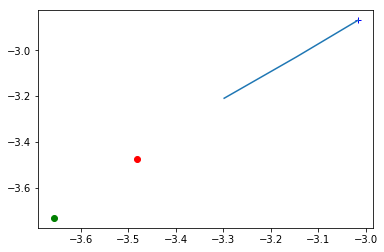

Variable containing:
 0.3629  0.1823  0.2016
 0.3629  0.1823  0.2016
 0.3629  0.1823  0.2016
[torch.DoubleTensor of size 3x3]

[[ 0.35779136  0.16775208  0.18353793]
 [ 0.36005785  0.1691125   0.17890532]]


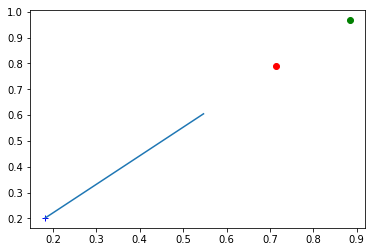

Variable containing:
 1.0464  0.4405 -0.0167
 1.0464  0.4405 -0.0167
 1.0464  0.4405 -0.0167
[torch.DoubleTensor of size 3x3]

[[ 1.0347563   0.39862121 -0.00968104]
 [ 1.03934328  0.38964854 -0.00311373]]


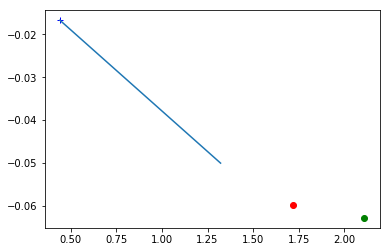

Variable containing:
 0.9361  0.0658 -0.2546
 0.9361  0.0658 -0.2546
 0.9361  0.0658 -0.2546
[torch.DoubleTensor of size 3x3]

[[ 0.93834581  0.07206305 -0.2490289 ]
 [ 0.94580261  0.08839369 -0.24061216]]


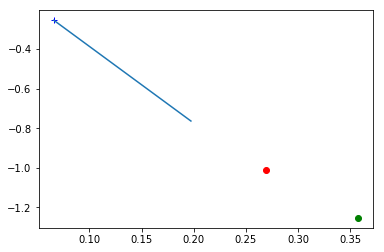

Variable containing:
 0.9292 -0.2120 -0.0475
 0.9292 -0.2120 -0.0475
 0.9292 -0.2120 -0.0475
[torch.DoubleTensor of size 3x3]

[[ 0.93207958 -0.22277286 -0.04330017]
 [ 0.93911828 -0.21779785 -0.03249534]]


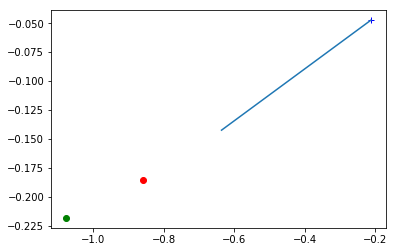

Variable containing:
 0.7170 -0.1893 -0.3185
 0.7170 -0.1893 -0.3185
 0.7170 -0.1893 -0.3185
[torch.DoubleTensor of size 3x3]

[[ 0.72881615 -0.17314281 -0.29499113]
 [ 0.73851152 -0.15176385 -0.28050507]]


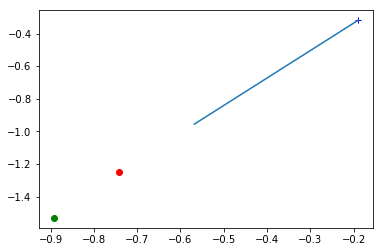

Variable containing:
 0.8144 -0.1332 -0.0411
 0.8144 -0.1332 -0.0411
 0.8144 -0.1332 -0.0411
[torch.DoubleTensor of size 3x3]

[[ 0.81894629 -0.12484801 -0.04150368]
 [ 0.82677574 -0.1097097  -0.03424854]]


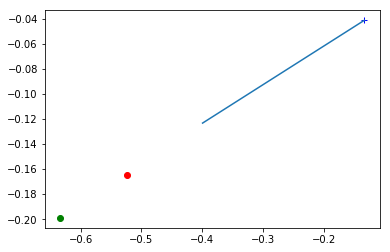

Variable containing:
 0.6591  0.2418  0.2899
 0.6547  0.1154  0.1168
 0.6452  0.1338  0.1419
[torch.DoubleTensor of size 3x3]

[[ 0.6450187   0.13919719  0.12892068]
 [ 0.64981542  0.14835316  0.1289293 ]]


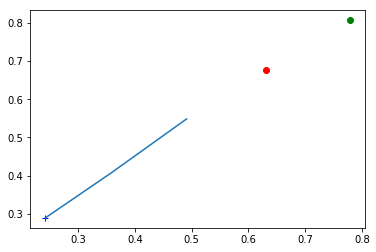

Variable containing:
 1.0998 -0.1614  0.2221
 1.0998 -0.1759  0.2416
 1.0998 -0.1127  0.1496
[torch.DoubleTensor of size 3x3]

[[ 1.09665944 -0.15855835  0.19856753]
 [ 1.10190468 -0.17442275  0.22047624]]


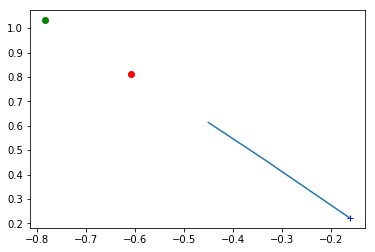

Variable containing:
 1.1977  0.1838 -0.0690
 1.2121  0.1915 -0.0712
 1.2121  0.1744 -0.0668
[torch.DoubleTensor of size 3x3]

[[ 1.2066519   0.171916   -0.08437742]
 [ 1.21135398  0.18204551 -0.08376288]]


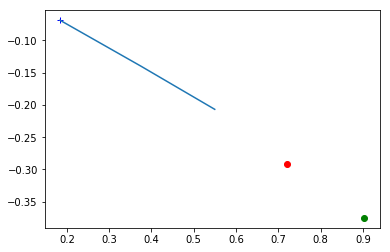

Variable containing:
 1.1707  0.1197 -0.2131
 1.1618  0.1187 -0.2357
 1.1545  0.1161 -0.2564
[torch.DoubleTensor of size 3x3]

[[ 1.15158532  0.12034758 -0.26988077]
 [ 1.15717454  0.13550366 -0.27082814]]


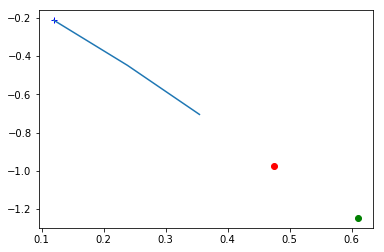

Variable containing:
 0.9976 -0.2013  0.1143
 0.9941 -0.2014  0.1136
 0.9941 -0.1931  0.1073
[torch.DoubleTensor of size 3x3]

[[ 0.99357305 -0.22531558  0.1214781 ]
 [ 0.99950211 -0.23370635  0.13799704]]


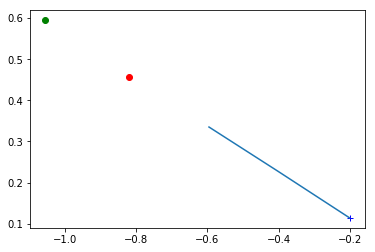

Variable containing:
 1.1431 -0.2984  0.4183
 1.1431 -0.2984  0.4183
 1.1431 -0.2984  0.4183
[torch.DoubleTensor of size 3x3]

[[ 1.13216523 -0.46608677  0.52894855]
 [ 1.13096704 -0.56749123  0.60528371]]


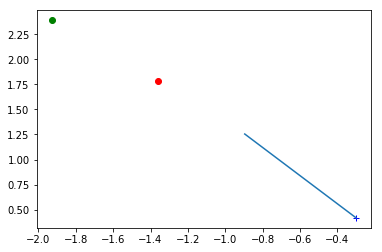

Variable containing:
 1.2959  0.1778 -0.2053
 1.3011  0.1738 -0.2009
 1.3011  0.1822 -0.2104
[torch.DoubleTensor of size 3x3]

[[ 1.2893349   0.17226719 -0.23724738]
 [ 1.29247412  0.1816752  -0.24263315]]


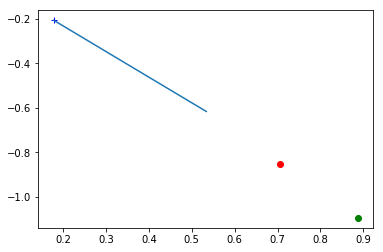

Variable containing:
 1.2238  0.5529 -0.5838
 1.2238  0.5529 -0.5838
 1.2238  0.5529 -0.5838
[torch.DoubleTensor of size 3x3]

[[ 1.21538034  0.47507736 -0.56915255]
 [ 1.22612089  0.45890331 -0.5636704 ]]


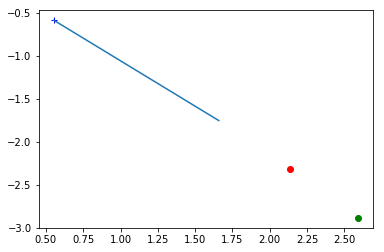

Variable containing:
 0.6400  0.5211  0.6721
 0.6444  0.1171  0.1203
 0.6539  0.1077  0.1063
[torch.DoubleTensor of size 3x3]

[[ 0.65920983  0.12115704  0.10704006]
 [ 0.66405545  0.131264    0.10606505]]


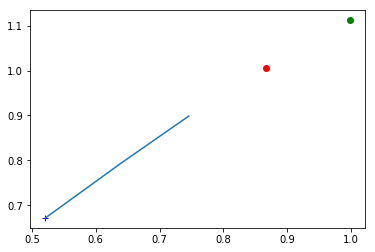

Variable containing:
 0.6305  0.9602  1.2790
 0.6305  0.9602  1.2790
 0.6305  0.9602  1.2790
[torch.DoubleTensor of size 3x3]

[[ 0.61856307  0.95931693  1.20883205]
 [ 0.62620108  0.96233645  1.20532014]]


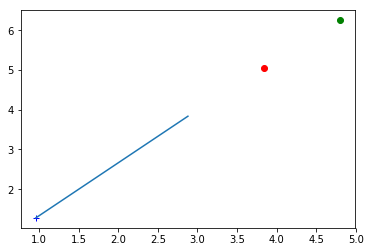

Variable containing:
 1.1144 -0.1714  0.2341
 1.1144 -0.1714  0.2341
 1.1144 -0.1714  0.2341
[torch.DoubleTensor of size 3x3]

[[ 1.11188971 -0.2432071   0.27586882]
 [ 1.11670812 -0.27900244  0.31025392]]


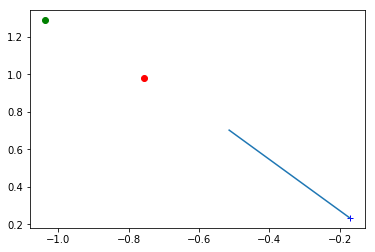

Variable containing:
 0.8192  0.1943  0.2220
 0.8192  0.1943  0.2220
 0.8192  0.1943  0.2220
[torch.DoubleTensor of size 3x3]

[[ 0.8164704   0.20680735  0.20219478]
 [ 0.82186505  0.21953858  0.20108543]]


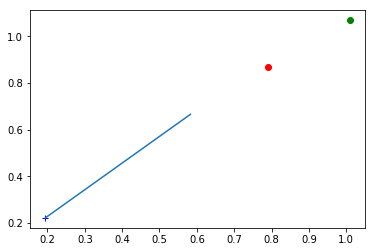

Variable containing:
 0.8410 -0.1479 -0.0414
 0.8410 -0.1479 -0.0414
 0.8410 -0.1479 -0.0414
[torch.DoubleTensor of size 3x3]

[[ 0.84538802 -0.14227608 -0.04152579]
 [ 0.85316566 -0.12847895 -0.03385928]]


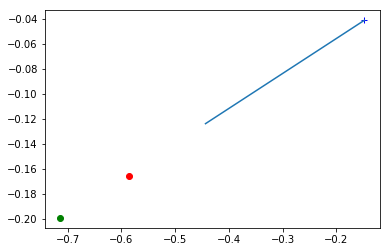

Variable containing:
 1.0380 -0.1511 -0.0420
 1.0376 -0.1245 -0.0401
 1.0376 -0.1713 -0.0438
[torch.DoubleTensor of size 3x3]

[[ 1.03988901 -0.18733017 -0.04029407]
 [ 1.04613691 -0.18737431 -0.02898371]]


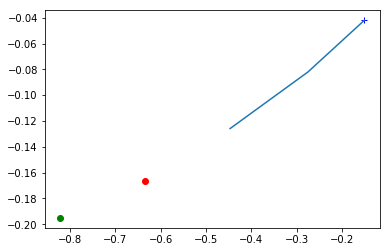

Variable containing:
 1.3086  0.1793  0.1142
 1.3086  0.1793  0.1142
 1.3086  0.1793  0.1142
[torch.DoubleTensor of size 3x3]

[[ 1.30547978  0.16684527  0.12255855]
 [ 1.31134761  0.17014311  0.13521093]]


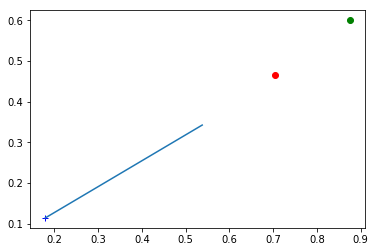

Variable containing:
 0.7412 -0.0239  0.2171
 0.7468 -0.0245  0.2282
 0.7534 -0.0172  0.1729
[torch.DoubleTensor of size 3x3]

[[ 0.7539728  -0.00204199  0.17491384]
 [ 0.76060796  0.01510526  0.17639708]]


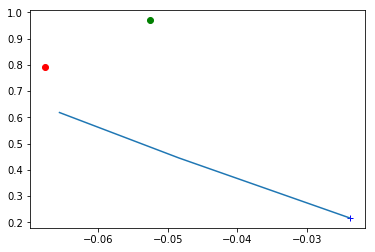

Variable containing:
-1.2872 -0.0549 -0.0391
-1.2872 -0.0549 -0.0391
-1.2872 -0.0549 -0.0391
[torch.DoubleTensor of size 3x3]

[[-1.27088969 -0.06032017 -0.03442198]
 [-1.25972519 -0.05511921 -0.03516679]]


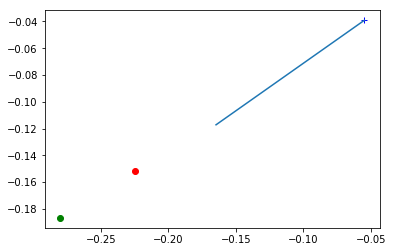

Variable containing:
 0.7704  0.0777 -0.1561
 0.7750  0.1335 -0.2607
 0.7750  0.1030 -0.2024
[torch.DoubleTensor of size 3x3]

[[ 0.77617906  0.09879548 -0.19153102]
 [ 0.78331123  0.10830482 -0.17801044]]


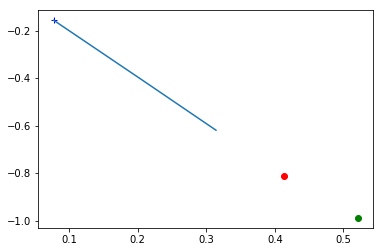

Variable containing:
 0.7321  0.1002 -0.1990
 0.7321  0.1002 -0.1990
 0.7321  0.1002 -0.1990
[torch.DoubleTensor of size 3x3]

[[ 0.73419904  0.09046471 -0.17401922]
 [ 0.74123481  0.09911413 -0.16005881]]


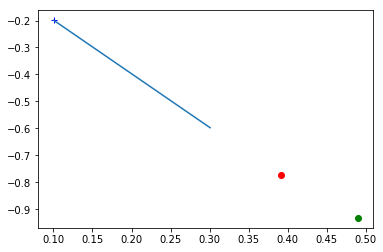

Variable containing:
 0.7584  0.0958 -0.2229
 0.7637  0.0951 -0.2211
 0.7637  0.0983 -0.2288
[torch.DoubleTensor of size 3x3]

[[ 0.7660833   0.08980559 -0.20168719]
 [ 0.77329133  0.09965088 -0.1874841 ]]


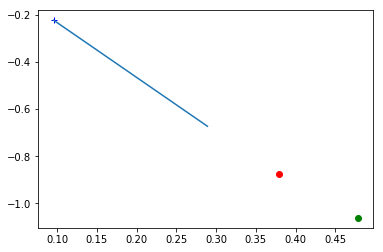

Variable containing:
 0.8490  0.5579  2.0228
 0.8490  0.5579  2.0228
 0.8490  0.5579  2.0228
[torch.DoubleTensor of size 3x3]

[[ 0.8604316   0.31482882  2.28490304]
 [ 0.90861591  0.16876734  2.51962604]]


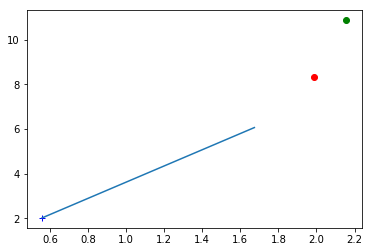

Variable containing:
 0.6323 -1.3121 -3.5881
 0.6323 -1.3121 -3.5881
 0.6323 -1.3121 -3.5881
[torch.DoubleTensor of size 3x3]

[[ 0.24548622 -1.91432639 -3.65858275]
 [ 0.06140547 -2.0742591  -3.6684087 ]]


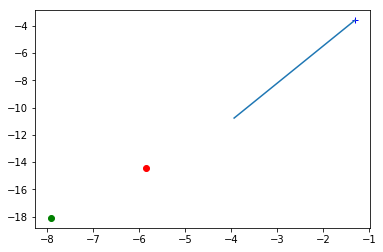

Variable containing:
 0.7579 -0.1243  0.2880
 0.7579 -0.0760  0.1755
 0.7579 -0.0776  0.1780
[torch.DoubleTensor of size 3x3]

[[ 0.75839863 -0.06429957  0.17279167]
 [ 0.7652514  -0.04841487  0.17600447]]


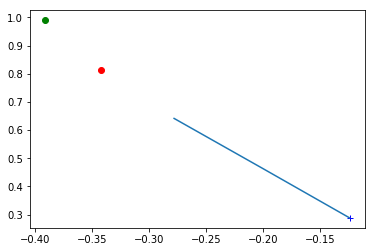

Variable containing:
-0.3320  0.0165 -0.2502
-0.3253  0.0140 -0.1830
-0.3222  0.0150 -0.1777
[torch.DoubleTensor of size 3x3]

[[-0.31130137  0.01294988 -0.18417422]
 [-0.30864521  0.02121394 -0.18478333]]


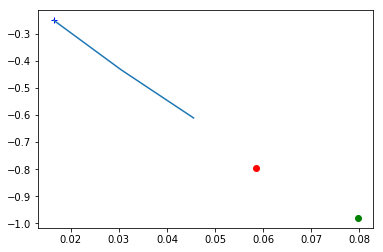

Variable containing:
-0.2711 -0.1963  0.2675
-0.2711 -0.1963  0.2675
-0.2711 -0.1963  0.2675
[torch.DoubleTensor of size 3x3]

[[-0.26780108 -0.1929304   0.26513687]
 [-0.26975408 -0.18286031  0.26391018]]


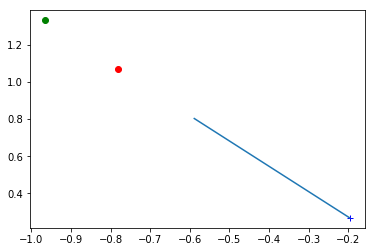

Variable containing:
-1.1514 -0.0486 -0.0191
-1.1514 -0.0486 -0.0191
-1.1514 -0.0486 -0.0191
[torch.DoubleTensor of size 3x3]

[[-1.12640826 -0.05775933 -0.00996047]
 [-1.11109712 -0.05587123 -0.00753176]]


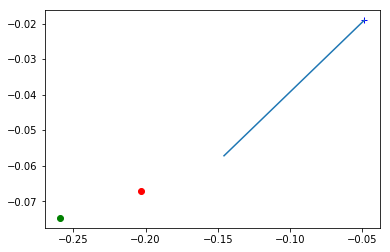

Variable containing:
-1.1823 -0.0467 -0.0181
-1.1533 -0.0480 -0.0390
-1.0533 -0.0456 -0.0750
[torch.DoubleTensor of size 3x3]

[[-1.02884818 -0.05831575 -0.06295227]
 [-1.01197056 -0.05668945 -0.06065066]]


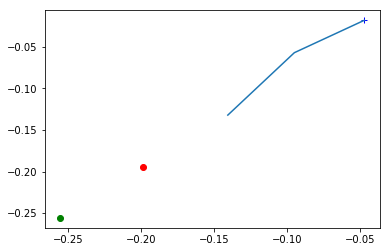

Variable containing:
 0.0912 -0.1892 -0.0028
 0.0871 -0.1750 -0.0028
 0.0863 -0.1798 -0.0111
[torch.DoubleTensor of size 3x3]

[[ 0.0879976  -0.16455137 -0.01585499]
 [ 0.08846759 -0.14861865 -0.01731457]]


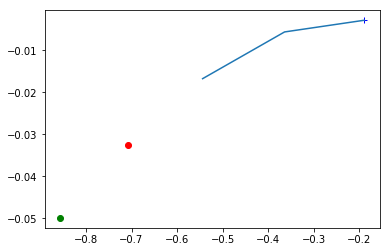

Variable containing:
 1.1207  0.2836  0.0652
 1.1184  0.0941  0.0010
 1.1237  0.4964  0.1300
[torch.DoubleTensor of size 3x3]

[[ 1.08660462  0.45707865  0.10601965]
 [ 1.08772917  0.4549443   0.11092399]]


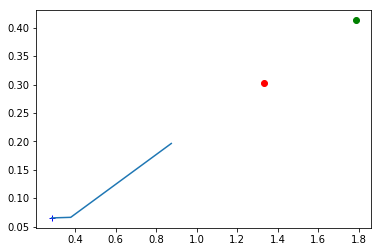

Variable containing:
-1.7337  0.0522 -0.0590
-1.7337  0.0522 -0.0590
-1.7337  0.0522 -0.0590
[torch.DoubleTensor of size 3x3]

[[-1.72280796  0.05030128 -0.05446437]
 [-1.71164558  0.06148031 -0.05685756]]


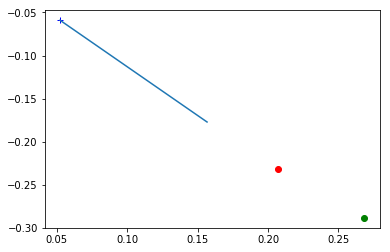

Variable containing:
-1.6162 -0.0278 -0.0663
-1.6162 -0.0278 -0.0663
-1.6162 -0.0278 -0.0663
[torch.DoubleTensor of size 3x3]

[[-1.61309141 -0.03281603 -0.06406929]
 [-1.60764113 -0.02399963 -0.06832901]]


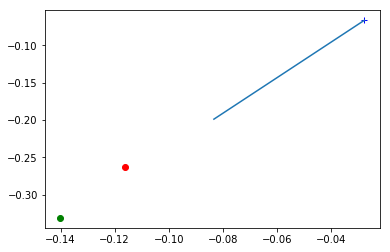

Variable containing:
-1.7594  0.0018 -0.0107
-1.7594 -0.0053  0.0076
-1.7546 -0.0159  0.0275
[torch.DoubleTensor of size 3x3]

[[-1.75312097 -0.03711304  0.01751666]
 [-1.74874501 -0.03587926  0.01011661]]


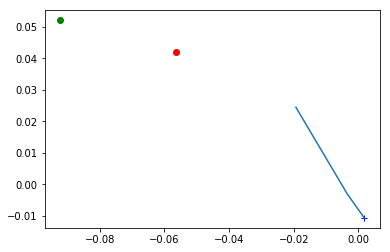

Variable containing:
-1.6585 -0.0202 -0.0691
-1.6471 -0.0228 -0.0672
-1.6414 -0.0192 -0.0684
[torch.DoubleTensor of size 3x3]

[[-1.63859909 -0.02538205 -0.06597055]
 [-1.63285009 -0.01638984 -0.07012146]]


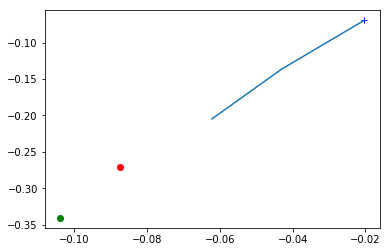

Variable containing:
-1.6605  0.0423 -0.0668
-1.6605  0.0423 -0.0668
-1.6605  0.0423 -0.0668
[torch.DoubleTensor of size 3x3]

[[-1.64967992  0.04685512 -0.06345772]
 [-1.63860901  0.06035706 -0.06600843]]


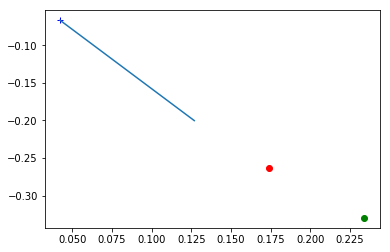

Variable containing:
-0.9287 -0.0552  0.0340
-0.9287 -0.0552  0.0340
-0.9287 -0.0552  0.0340
[torch.DoubleTensor of size 3x3]

[[-0.89512572 -0.07466134  0.0490839 ]
 [-0.87686719 -0.07911048  0.0552871 ]]


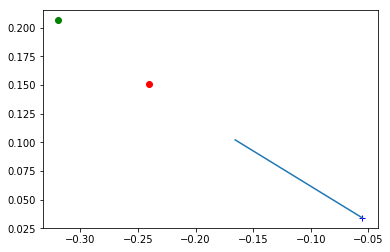

Variable containing:
-1.6215 -0.0113 -0.0781
-1.6215 -0.0113 -0.0781
-1.6215 -0.0113 -0.0781
[torch.DoubleTensor of size 3x3]

[[ -1.61625511e+00  -1.21338472e-02  -7.48899449e-02]
 [ -1.60928279e+00  -1.32854064e-03  -7.84560839e-02]]


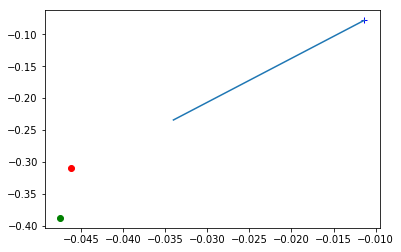

Variable containing:
-1.2457  0.0597  0.0358
-1.2457  0.0597  0.0358
-1.2457  0.0597  0.0358
[torch.DoubleTensor of size 3x3]

[[-1.21387951  0.06665679  0.03992809]
 [-1.19205702  0.07652037  0.0417036 ]]


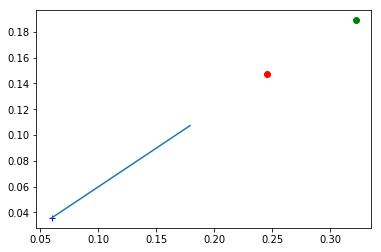

Variable containing:
-1.5656 -0.0467 -0.0569
-1.5396 -0.0432 -0.0617
-1.5232 -0.0429 -0.0624
[torch.DoubleTensor of size 3x3]

[[-1.51982904 -0.04666235 -0.06315759]
 [-1.51396983 -0.03773905 -0.06771213]]


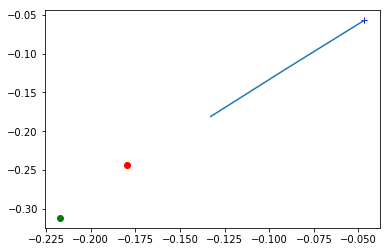

Variable containing:
-1.3899  0.0819  0.0015
-1.3899  0.0819  0.0015
-1.3899  0.0819  0.0015
[torch.DoubleTensor of size 3x3]

[[-1.36414261  0.09729402  0.00182046]
 [-1.34452     0.11265486  0.00144506]]


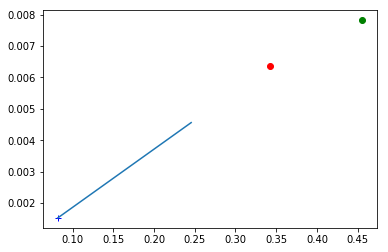

Variable containing:
-1.4509 -0.0555 -0.0555
-1.4509 -0.0555 -0.0555
-1.4509 -0.0555 -0.0555
[torch.DoubleTensor of size 3x3]

[[-1.44421493 -0.05976211 -0.05420887]
 [-1.43768553 -0.05217885 -0.05791726]]


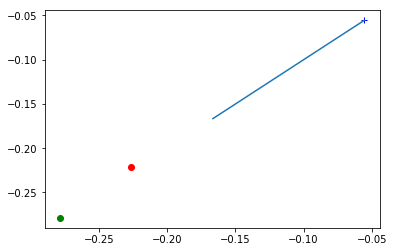

Variable containing:
-1.5478  0.0865  0.0170
-1.5459  0.0693  0.0049
-1.5402  0.0654  0.0038
[torch.DoubleTensor of size 3x3]

[[ -1.52327674e+00   7.77746211e-02  -1.61081738e-04]
 [ -1.50820077e+00   9.25995636e-02  -3.72263179e-03]]


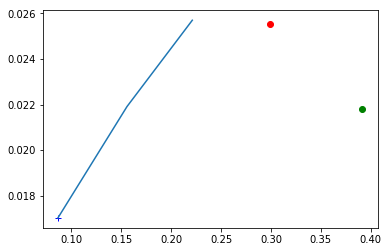

Variable containing:
-1.7503  0.0545 -0.0394
-1.7438  0.0572 -0.0378
-1.7438  0.0538 -0.0371
[torch.DoubleTensor of size 3x3]

[[-1.73307554  0.04940077 -0.03509702]
 [-1.72197462  0.05927978 -0.03834482]]


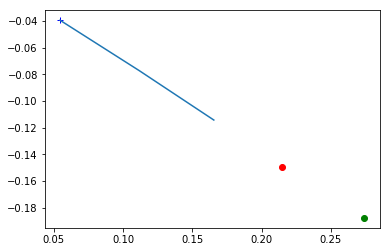

Variable containing:
-1.6317  0.0621 -0.0243
-1.6317  0.0621 -0.0243
-1.6317  0.0621 -0.0243
[torch.DoubleTensor of size 3x3]

[[-1.618503    0.06773666 -0.02529873]
 [-1.60561472  0.08149093 -0.02875127]]


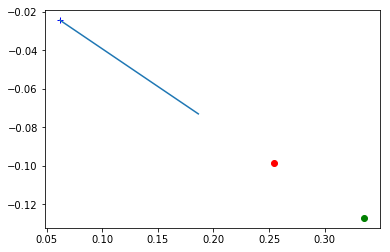

Variable containing:
-1.4116 -0.0583 -0.0577
-1.4116 -0.0583 -0.0577
-1.4116 -0.0583 -0.0577
[torch.DoubleTensor of size 3x3]

[[-1.40303611 -0.06232076 -0.05567417]
 [-1.39568494 -0.05503602 -0.05879765]]


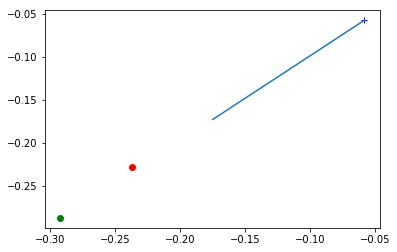

Variable containing:
-1.4971 -0.0531 -0.0035
-1.4971 -0.0531 -0.0035
-1.4971 -0.0531 -0.0035
[torch.DoubleTensor of size 3x3]

[[-1.49316116 -0.06335257 -0.00528871]
 [-1.48787066 -0.0580758  -0.01052483]]


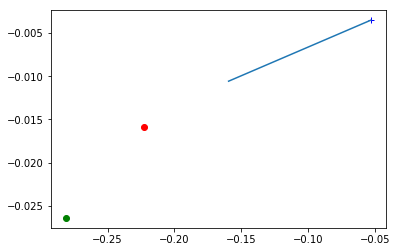

Variable containing:
-1.4945  0.0734 -0.0502
-1.4945  0.0734 -0.0502
-1.4945  0.0734 -0.0502
[torch.DoubleTensor of size 3x3]

[[-1.47483297  0.09085334 -0.04896141]
 [-1.45843392  0.1084586  -0.05010342]]


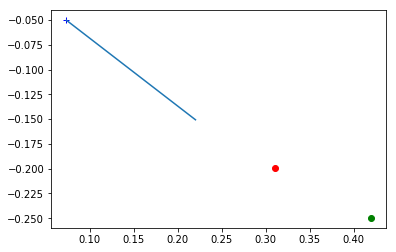

Variable containing:
-1.6203  0.0332  0.0155
-1.6203  0.0332  0.0155
-1.6203  0.0332  0.0155
[torch.DoubleTensor of size 3x3]

[[-1.61100879  0.03092422  0.01065948]
 [-1.60071544  0.04115445  0.00509521]]


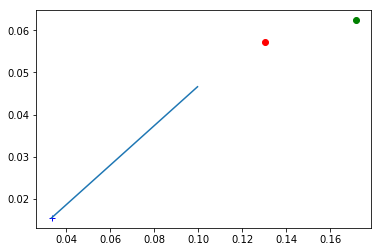

Variable containing:
-1.4288  0.0812 -0.0041
-1.4288  0.0812 -0.0041
-1.4288  0.0812 -0.0041
[torch.DoubleTensor of size 3x3]

[[-1.40518531  0.09684469 -0.0045722 ]
 [-1.38658963  0.11281089 -0.00559863]]


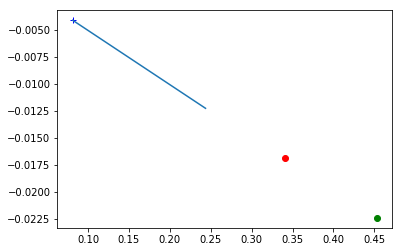

Variable containing:
-1.4619  0.0648 -0.0877
-1.4619  0.0476 -0.0668
-1.4714  0.0555 -0.0739
[torch.DoubleTensor of size 3x3]

[[-1.45180236  0.07168534 -0.06919696]
 [-1.43647932  0.08904467 -0.06992214]]


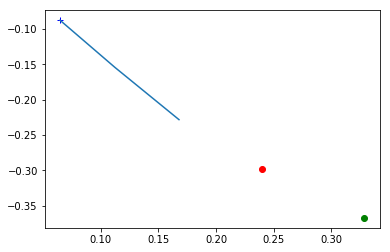

Variable containing:
-1.6068 -0.0002 -0.0793
-1.6106  0.0046 -0.0497
-1.6106 -0.0020 -0.1004
[torch.DoubleTensor of size 3x3]

[[-1.60471362  0.00212944 -0.08421792]
 [-1.59662263  0.01445884 -0.08683565]]


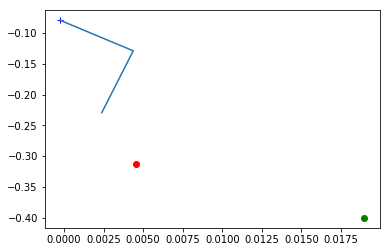

Variable containing:
-0.7125  0.0106 -0.1324
-0.7192  0.0113 -0.1437
-0.7125  0.0119 -0.1511
[torch.DoubleTensor of size 3x3]

[[-0.68405428  0.01103213 -0.14432773]
 [-0.67054732  0.01688283 -0.14233866]]


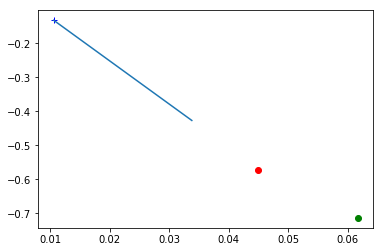

Variable containing:
-1.5699 -0.0072 -0.0820
-1.5617 -0.0086 -0.0798
-1.5580 -0.0093 -0.0792
[torch.DoubleTensor of size 3x3]

[[-1.55044558 -0.0052732  -0.07772706]
 [-1.54212832  0.00714565 -0.08111964]]


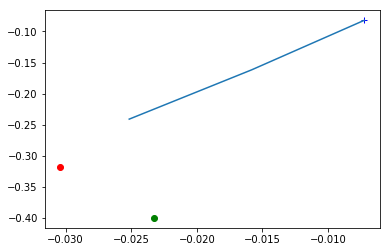

Variable containing:
-1.6783 -0.0057  0.0145
-1.6802 -0.0088  0.0109
-1.6842 -0.0100  0.0122
[torch.DoubleTensor of size 3x3]

[[-1.68174138 -0.02486633  0.0084936 ]
 [-1.6764003  -0.02017986  0.00188296]]


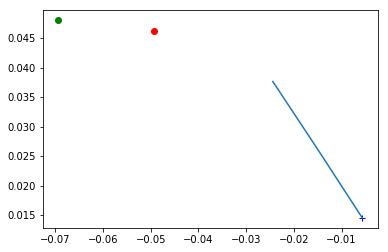

Variable containing:
-1.6364  0.0304  0.0080
-1.6364  0.0304  0.0080
-1.6364  0.0304  0.0080
[torch.DoubleTensor of size 3x3]

[[ -1.62786547e+00   2.69918902e-02   3.89391842e-03]
 [ -1.61807080e+00   3.68594598e-02  -1.58095043e-03]]


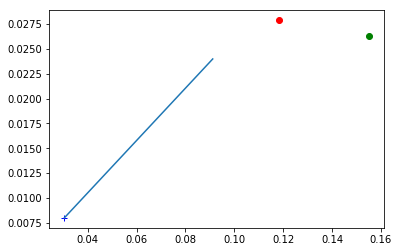

Variable containing:
-0.8130  0.0066  0.0238
-0.8130  0.0066  0.0238
-0.8130  0.0066  0.0238
[torch.DoubleTensor of size 3x3]

[[-0.7762783  -0.00415666  0.0347175 ]
 [-0.7569613  -0.00417141  0.03942686]]


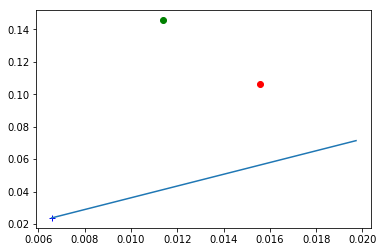

Variable containing:
-1.1967 -0.0324 -0.1268
-1.1967 -0.0324 -0.1268
-1.1967 -0.0324 -0.1268
[torch.DoubleTensor of size 3x3]

[[-1.17348069 -0.02803137 -0.1192625 ]
 [-1.1589827  -0.01897726 -0.1178394 ]]


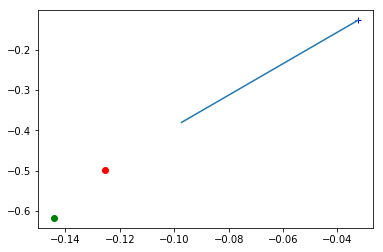

Variable containing:
-1.2781  0.0276  0.0520
-1.2781  0.0276  0.0520
-1.2781  0.0276  0.0520
[torch.DoubleTensor of size 3x3]

[[-1.25129529  0.02962628  0.05423085]
 [-1.23254688  0.03788829  0.05439144]]


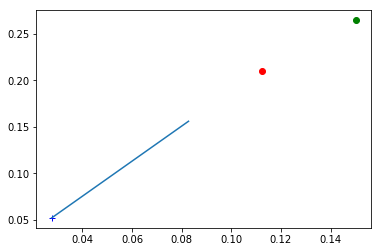

Variable containing:
-1.4481 -0.0908 -1.1603
-1.4481 -0.0908 -1.1603
-1.4481 -0.0908 -1.1603
[torch.DoubleTensor of size 3x3]

[[-1.35838438  0.09335258 -1.40034095]
 [-1.30607947  0.20817818 -1.56682416]]


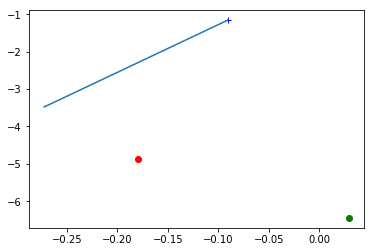

Variable containing:
-1.4770 -0.0317 -0.0445
-1.4770 -0.0317 -0.0445
-1.4770 -0.0317 -0.0445
[torch.DoubleTensor of size 3x3]

[[-1.46899313 -0.03277377 -0.04416626]
 [-1.46110958 -0.0234099  -0.04799462]]


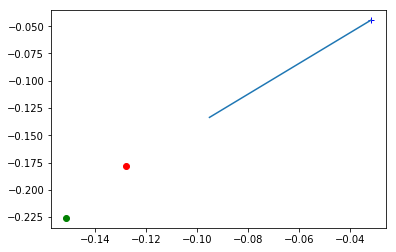

Variable containing:
-0.9656 -0.0623 -0.0454
-0.9590 -0.0760 -0.0458
-0.9590 -0.0604 -0.0442
[torch.DoubleTensor of size 3x3]

[[-0.92897176 -0.07888797 -0.03129692]
 [-0.9128409  -0.0808733  -0.02645784]]


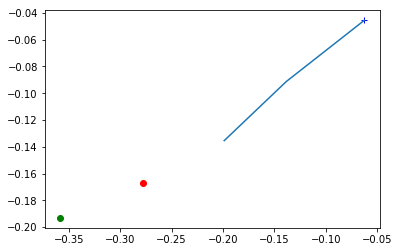

Variable containing:
-1.2574 -0.0481 -0.0684
-1.2574 -0.0481 -0.0684
-1.2574 -0.0481 -0.0684
[torch.DoubleTensor of size 3x3]

[[-1.23866074 -0.05012139 -0.06259411]
 [-1.22631878 -0.0436022  -0.06254574]]


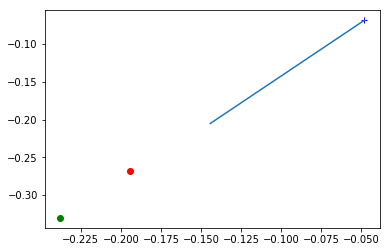

Variable containing:
-1.4729 -0.0357 -0.0370
-1.4743 -0.0308 -0.0381
-1.4860 -0.0321 -0.0364
[torch.DoubleTensor of size 3x3]

[[-1.47782272 -0.03424618 -0.03581597]
 [-1.47026089 -0.02539845 -0.03973821]]


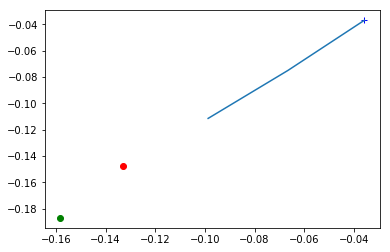

Variable containing:
-1.3171 -0.0435 -0.0215
-1.3171 -0.0435 -0.0215
-1.3171 -0.0435 -0.0215
[torch.DoubleTensor of size 3x3]

[[-1.30125719 -0.04772886 -0.01825472]
 [-1.28994814 -0.0416357  -0.01962077]]


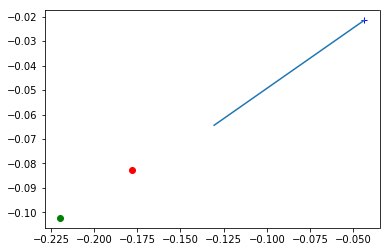

Variable containing:
-1.2080 -0.0468 -0.0205
-1.2080 -0.0468 -0.0205
-1.2080 -0.0468 -0.0205
[torch.DoubleTensor of size 3x3]

[[-1.18599146 -0.05394464 -0.01337295]
 [-1.17191888 -0.05047229 -0.01221659]]


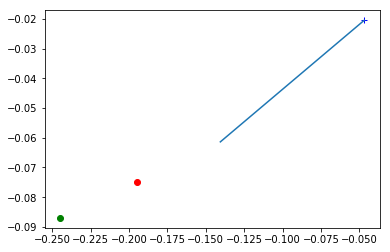

Variable containing:
-0.5663 -0.0870 -0.0827
-0.5663 -0.0870 -0.0827
-0.5663 -0.0870 -0.0827
[torch.DoubleTensor of size 3x3]

[[-0.54836652 -0.09113378 -0.08568051]
 [-0.54234342 -0.08591986 -0.08720776]]


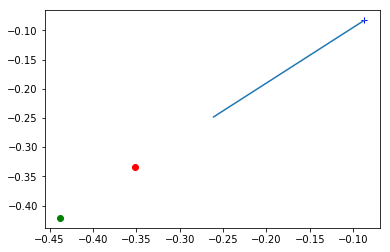

Variable containing:
-1.1089 -0.0616 -0.0052
-1.1089 -0.0616 -0.0052
-1.1089 -0.0616 -0.0052
[torch.DoubleTensor of size 3x3]

[[-1.08271522 -0.07561923  0.00575198]
 [-1.06722608 -0.07648803  0.00917007]]


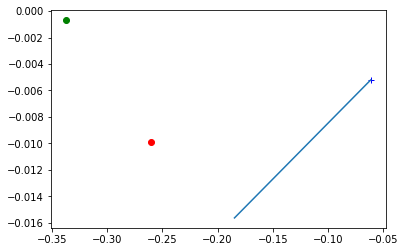

Variable containing:
-1.2298  0.0194 -0.0141
-1.2298  0.0194 -0.0141
-1.2298  0.0194 -0.0141
[torch.DoubleTensor of size 3x3]

[[-1.2021726   0.02400817 -0.00833981]
 [-1.18363879  0.03296284 -0.00674945]]


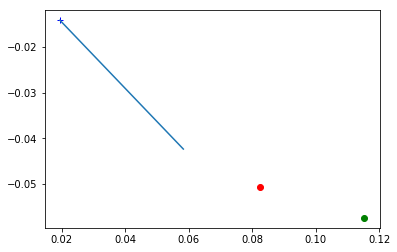

Variable containing:
-1.8774  0.0347 -0.0243
-1.8774  0.0347 -0.0243
-1.8774  0.0347 -0.0243
[torch.DoubleTensor of size 3x3]

[[-1.86867852  0.00642882 -0.0184254 ]
 [-1.85982836  0.00709033 -0.02177596]]


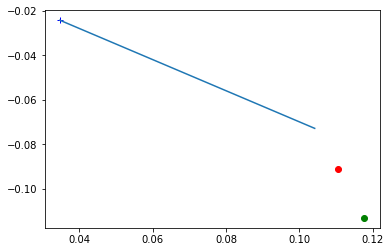

Variable containing:
-1.1718 -0.0820 -0.2220
-1.1718 -0.0820 -0.2220
-1.1718 -0.0820 -0.2220
[torch.DoubleTensor of size 3x3]

[[-1.15178931 -0.079243   -0.21556417]
 [-1.14052065 -0.07071955 -0.21530841]]


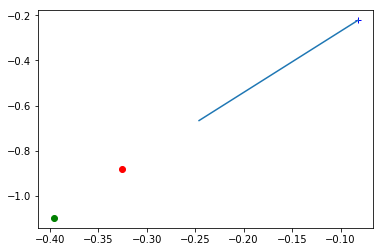

Variable containing:
-1.7810  0.0417 -0.0282
-1.7810  0.0417 -0.0282
-1.7810  0.0417 -0.0282
[torch.DoubleTensor of size 3x3]

[[-1.77239573  0.02868631 -0.02561516]
 [-1.76280356  0.03537571 -0.02938714]]


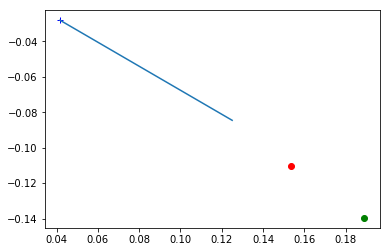

Variable containing:
-1.4828  0.0457  0.0183
-1.4772  0.0429  0.0106
-1.4817  0.0409  0.0099
[torch.DoubleTensor of size 3x3]

[[-1.46494477  0.0491368   0.00723408]
 [-1.45087424  0.06225355  0.00381175]]


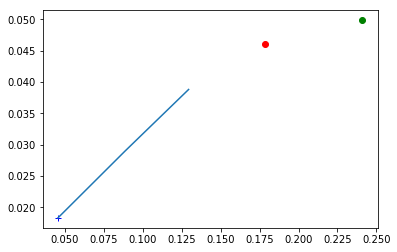

Variable containing:
-1.1385  0.0091 -0.2007
-1.1385  0.0091 -0.2007
-1.1385  0.0091 -0.2007
[torch.DoubleTensor of size 3x3]

[[-1.10928563  0.02476644 -0.19191735]
 [-1.09167176  0.03852545 -0.18890815]]


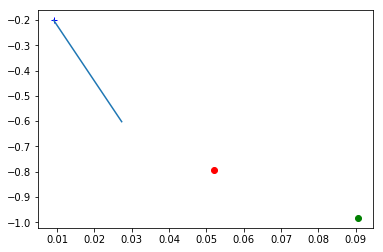

Variable containing:
-1.2807  0.0096 -0.1093
-1.2807  0.0096 -0.1093
-1.2807  0.0096 -0.1093
[torch.DoubleTensor of size 3x3]

[[-1.25741686  0.02238755 -0.10314739]
 [-1.24149513  0.0359504  -0.10215708]]


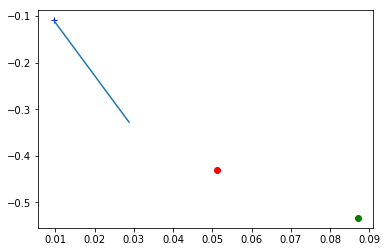

Variable containing:
-1.3686 -0.5732  0.2846
-1.3686 -0.5732  0.2846
-1.3686 -0.5732  0.2846
[torch.DoubleTensor of size 3x3]

[[-1.41559164 -0.76195701  0.34239535]
 [-1.45633808 -0.86257442  0.36863732]]


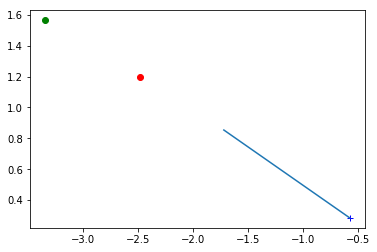

Variable containing:
-0.7929  0.0077 -0.1287
-0.7929  0.0077 -0.1287
-0.7929  0.0077 -0.1287
[torch.DoubleTensor of size 3x3]

[[-0.7611      0.00622684 -0.1212518 ]
 [-0.74516604  0.01108798 -0.11798803]]


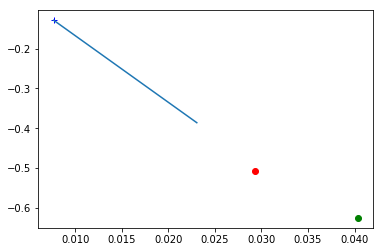

In [22]:
test_pred = seq(test_input,future).data.squeeze(1).numpy()
test_pred_latlon = test_pred[:, :, -2:]
# print(test_pred.shape)
for i in range(test_input.size(0)):
    latlon = test_input[i].data.numpy()[:, -2:]
    latlon = np.insert(latlon, latlon.shape[0], test_pred_latlon[i], axis=0)
    path = latlon.cumsum(axis=0)
    print(test_input[i])
    print(test_pred[i])
    pathx, pathy = np.split(path, 2, axis=1)
    plt.plot(pathx[0], pathy[0], 'b+')
    plt.plot(pathx[:-future], pathy[:-future])
    
    plt.plot(pathx[-2], pathy[-2], 'ro')
    plt.plot(pathx[-1], pathy[-1], 'go')
    plt.show()

In [23]:
h_t = Variable(torch.zeros(1, 5).float(), requires_grad=False)
c_t = Variable(torch.zeros(1, 5).float(), requires_grad=False)
cell = nn.LSTMCell(5, 5)

ip = Variable(torch.from_numpy(np.array([0., 1., 2., 3., 4.])).float(), requires_grad=False)
print(cell(ip.unsqueeze(0), (h_t, c_t)))
ip = Variable(torch.from_numpy(np.array([1., 1., 2., 3., 4.])).float(), requires_grad=False)
print(cell(ip.unsqueeze(0), (h_t, c_t)))

(Variable containing:
 0.4732  0.0046  0.0536  0.3493  0.0388
[torch.FloatTensor of size 1x5]
, Variable containing:
 0.6276  0.0436  0.1776  0.5844  0.5894
[torch.FloatTensor of size 1x5]
)
(Variable containing:
 0.5196  0.0066  0.0654  0.2769  0.0279
[torch.FloatTensor of size 1x5]
, Variable containing:
 0.7471  0.0511  0.2701  0.5194  0.5485
[torch.FloatTensor of size 1x5]
)


In [24]:
x = np.reshape(np.arange(60), (3, 5, 4))

In [25]:
x = np.reshape(x, (-1, 4))
print(x)
print(np.mean(x, axis=0))

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]
 [20 21 22 23]
 [24 25 26 27]
 [28 29 30 31]
 [32 33 34 35]
 [36 37 38 39]
 [40 41 42 43]
 [44 45 46 47]
 [48 49 50 51]
 [52 53 54 55]
 [56 57 58 59]]
[ 28.  29.  30.  31.]
